In [1]:
import crispr_assembler as ca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

%load_ext autoreload
%autoreload 2

import pickle

In [2]:
def process_path(path, cut = -1, save = 1):
    pairs_path = path + "/out/pairs/"
    files = sorted(os.listdir(pairs_path))
    
    print(pairs_path + files[0])
    
    read = ca.Read(pairs_path + files[0])
    read.correct_errors(minimum_occurences=5)
    gr = read.graph_from_pairs()[0]
    
    print('calc embs')
    ec = ca.EmbeddingsCalculator()
    ec.make_argsorts(gr[:cut, :cut])
    embs = ec.fit_predict(gr[:cut, :cut], njobs=32)
    
    if save:
        pickle.dump(read, open(path + "/read", 'wb'))
        np.save(path + "/graph", gr)
        np.save(path + "/embs", embs)
        
    return read, gr, embs

In [3]:
def load(path):
    return pickle.load(open(path + "/read", 'rb')), np.load(path + "/graph.npy"), np.load(path + "/embs.npy")

In [4]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [5]:
def continue_steps(reads, pointers):
    return any([pointers[i] < len(reads[i]) for i in range(len(reads))])

In [6]:
def merge_reads(reads, t=1, v = 1):
    spacers_lists = [unwrap_idx_to_spacer(x) for x in reads]#[unwrap_idx_to_spacer(x.index_to_cluster) for x in reads]
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = {}
    old_idx_to_new_idx = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(spacers_lists, pointers):
        for i in range(len(reads)):
            if pointers[i] < len(reads[i]):
                spacer = spacers_lists[i][pointers[i]]
                
                dist, closest = ca.find_closest(merged_sp_to_idxes, spacer)
                if dist > t:
                    merged_sp_to_idxes[spacer] = curr
                    #new_sp_to_ids[i][spacer] = curr
                    old_idx_to_new_idx[i][pointers[i]] = curr
                    curr += 1
                else:
                    old_idx_to_new_idx[i][pointers[i]] = merged_sp_to_idxes[closest]
                
                pointers[i] += 1
                
                if curr % 100 == 0:
                    print(curr)
                

                if v:
                    print(i, pointers[i], spacer, dist, merged_sp_to_idxes)#, new_sp_to_ids[1])
                    
    return merged_sp_to_idxes,  old_idx_to_new_idx

In [7]:
def rearange(gr, order):
    new_gr = np.zeros((max(order.values()) + 1, max(order.values()) + 1))

    for i in tqdm.tqdm(range(len(order.keys()))):
        for j in range(len(order.keys())):
            new_gr[order[i], order[j]] = gr[i, j]

    return new_gr

In [9]:
read_slv, gr_slv, emb_slv = process_path("../../data/environmental/m1/")

  0%|          | 0/365 [00:00<?, ?it/s]

../../data/environmental/m1//out/pairs/M1_AGTCAA_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 365/365 [00:00<00:00, 2363.45it/s]


calc embs


In [10]:
#answer_sensivity = ca.read_arrays_with_tags("../../article/data/answers/sensivity", 0)
answer = ca.read_arrays_with_tags("../../article/data/answers/all", 0)

In [11]:
a, d = ca.multiple_arrays_to_ids(answer, read_slv.spacer_to_cluster_index)

#a_all, d_all = ca.multiple_arrays_to_ids(answer_all, res.spacer_to_cluster_index)

answ_gr = ca.graph_from_arrays([x for x in a.values()], gr_slv.shape[0])[0]

100%|██████████| 54/54 [00:00<00:00, 110.56it/s]


In [12]:
d

{'first_1': [0, 10, 13, 14, 13, 14, 14],
 'first_11': [0, 10, 13, 14, 13, 14, 14],
 'first_2': [2, 13, 2, 2, 14],
 'first_24': [2, 13, 2, 2, 14],
 'first_61': [2, 13, 2, 2, 14],
 'first_62': [2, 13, 2, 2, 14],
 'first_68': [2, 13, 2, 2, 14],
 'first_3': [1, 14, 14, 14, 12, 14, 14],
 'first_5': [0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0],
 'first_50': [0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0],
 'first_7': [13, 12, 13, 14, 14, 13, 14, 13, 13],
 'first_8': [0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_14': [0, 0, 0, 13, 13, 0, 14, 0, 0, 12, 14, 15],
 'first_15': [0,
  10,
  13,
  14,
  14,
  13,
  13,
  13,
  14,
  13,
  14,
  14,
  14,
  15,
  13,
  14,
  14,
  14,
  14],
 'first_19': [0, 0, 0, 13, 13, 0, 0, 14],
 'first_20': [0, 0, 0, 13, 13, 0, 0, 14],
 'first_22': [0, 0, 0, 13, 13, 0, 0, 14],
 'first_31': [0, 0, 0, 13, 13, 0, 0, 14],
 'first_21': [0, 0, 0, 0, 0, 0, 0, 0, 14, 12, 13],
 'first_23': [0, 0, 0, 0, 0, 0, 0, 0, 14, 12, 13],
 'first_27': [0, 10, 13, 13, 13, 14, 15, 13, 14, 14, 14, 14, 13, 1

In [13]:
arrays_found_d = []
for k,v in d.items():
    if max(sorted(v)[::-1][:]) < 3:
        arrays_found_d.append(k)

In [14]:
arrays_found_v = []
for k,v in a.items():
    #print(k, sorted(v)[::-1])
    if max(sorted(v)[::-1][1:]) < 300:
        arrays_found_v.append(k)

In [15]:
arrays_found_d

['second_1', 'second_11', 'second_67']

In [16]:
set(arrays_found_v).intersection(set(arrays_found_d))

{'second_1', 'second_11', 'second_67'}

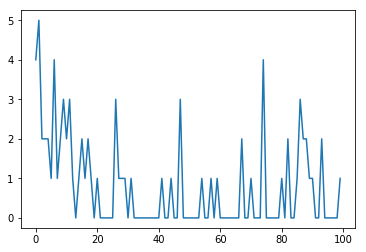

In [17]:
plt.plot((answ_gr > 0).sum(1)[:100])

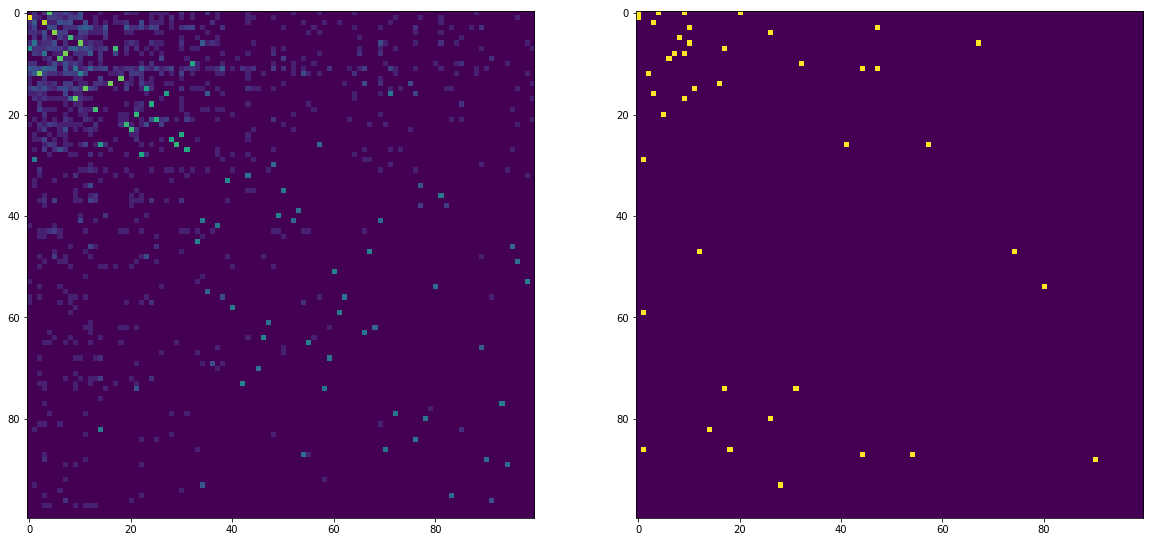

In [18]:
cut1 = 0
cut2 = 100
ca.plot_grs(gr_slv[cut1:cut2, cut1:cut2],
           (answ_gr[cut1:cut2, cut1:cut2] > 0).astype(int),
#             grs_m[1][:cut, :cut],
#             grs_m[2][:cut, :cut],
            log = 1, 
            s = 20)
plt.show()

In [19]:
gb = pickle.load(open("../article/linear_svc_rep_to_rep", 'rb'))

#pred = gb.predict(embs[0]).reshape((grs[0].shape[0] - 1, grs[0].shape[1] - 1))

In [20]:
pred = gb.predict(emb_slv).reshape((gr_slv.shape[0] - 1, gr_slv.shape[1] - 1))

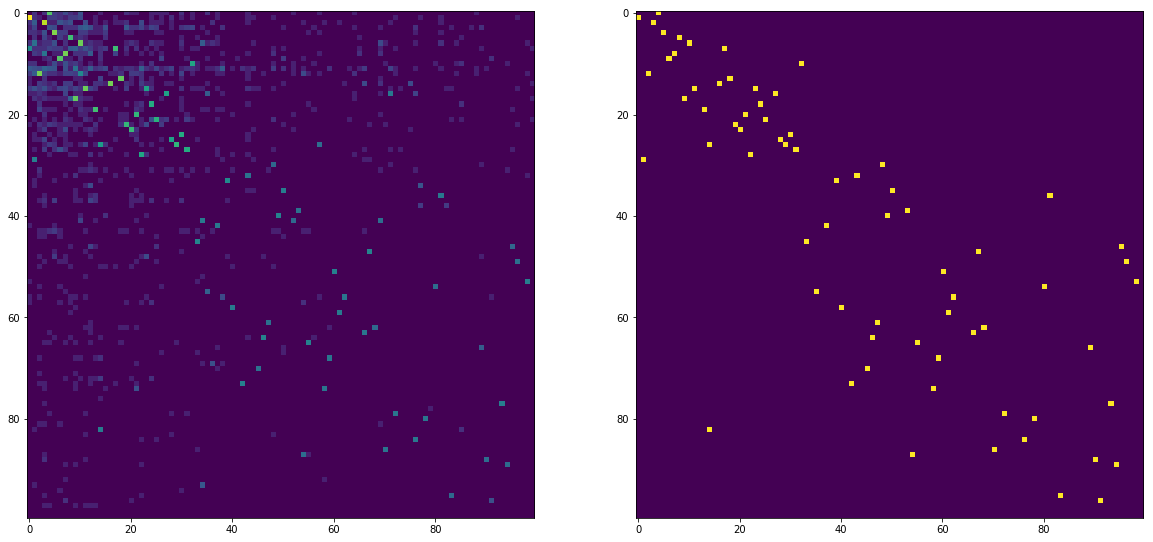

In [21]:
cut = 100
ca.plot_grs(gr_slv[:cut, :cut],
            pred[:cut, :cut],
            log = 1, 
            s = 20, subplots_form = (1,2))
plt.show()

In [22]:
arrs_slv = [x for x in ca.restore_arrays_greedy(gr_slv, 2)[0] if len(x) > 2]

In [23]:
arrs_slv

[[161, 26, 29, 1, 0, 4, 5, 8, 7, 17, 9, 6, 10, 32, 43],
 [15, 11, 12, 2, 3, 151],
 [82, 14, 16, 27, 31],
 [23, 20, 21, 25, 28, 22, 19, 13, 18, 24, 30, 48],
 [97, 102, 123, 86, 70, 45, 33, 39, 53, 98],
 [64, 46, 95, 83, 113, 195],
 [165, 56, 62, 68, 59, 61, 47, 67, 147, 155, 160, 162],
 [128, 114, 144, 108, 74, 58, 40, 49, 96, 91, 111],
 [65, 55, 35, 50],
 [73, 42, 37],
 [124, 51, 60, 131],
 [41, 34, 77, 93],
 [212, 103, 75, 119, 52, 185],
 [189, 84, 76, 105, 38, 115, 87, 54, 80, 78, 136, 188],
 [112, 36, 81],
 [142, 79, 72, 143],
 [117, 63, 66, 89, 94, 182, 109, 126, 125, 100, 92, 145],
 [101, 44, 104],
 [116, 99, 225],
 [239, 118, 121, 238],
 [169, 88, 90, 150],
 [127, 85, 107, 158, 120, 146],
 [152, 106, 133],
 [207, 110, 176],
 [168, 122, 148, 181],
 [205, 157, 170],
 [200, 130, 174],
 [180, 134, 173],
 [251, 184, 149],
 [138, 129, 159]]

In [25]:
for k,v in a.items():
    #if max(d[k]) < 5:
    print(k, sorted(d[k]))
    for i in ca.print_alignments(ca.water_alignments(v, arrs_slv), v):
        print(i)

first_1 [0, 10, 13, 13, 14, 14, 14]
 189, 174, 180, 131, 158, 153, 114,
first_11 [0, 10, 13, 13, 14, 14, 14]
 189, 174, 180, 131, 158, 153, 114,
first_2 [2, 2, 2, 13, 14]
 26 , 109, 197, 177, 210,
first_24 [2, 2, 2, 13, 14]
 26 , 109, 197, 177, 210,
first_61 [2, 2, 2, 13, 14]
 26 , 109, 197, 177, 210,
first_62 [2, 2, 2, 13, 14]
 26 , 109, 197, 177, 210,
first_68 [2, 2, 2, 13, 14]
 26 , 109, 197, 177, 210,
first_3 [1, 12, 14, 14, 14, 14, 14]
 177, 167, 131, 127, 223, 11 , 44 ,
first_5 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13]
 -  , -  , 29 , 1  , 0  , 4  , 140, 20 , 5  , 8  , 7  , 17 , 9  ,
 161, 26 , 29 , 1  , 0  , 4  , 5  , 8  , 7  , 17 , 9  , 6  , 10 , 32 , 43 ,
first_50 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13]
 -  , -  , 29 , 1  , 0  , 4  , 140, 20 , 5  , 8  , 7  , 17 , 9  ,
 161, 26 , 29 , 1  , 0  , 4  , 5  , 8  , 7  , 17 , 9  , 6  , 10 , 32 , 43 ,
first_7 [12, 13, 13, 13, 13, 13, 14, 14, 14]
 3  , 47 , 74 , 239, 236, 163, 237, 167, 172,
first_8 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13]
 -  , -  , 

In [56]:
ca.print_alignments(ca.water_alignments(v, arrs_slv), v)

[' 95 , 36 , 198, 104, 16 ,']

In [54]:
v

[95, 36, 198, 104, 16]